In [1]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

import inspect
from typing import List, Optional, Union

import numpy as np
import torch
import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

/home/taejukwon/anaconda3/envs/textdiffuser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cv2
import glob, os
import easyocr

In [3]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")

In [4]:
def get_OCR_result(init_img):
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,'
    reader = easyocr.Reader(['ko', 'en'])
    result = reader.readtext(np.array(init_img)) # PIL to cv2 (but RGB is not changed)
    
    return result

def make_mask_image(init_img, mask_text):
    result = get_OCR_result(init_img)
    
    for pts, text, p in result :
        if text == mask_text :
            mask_img = np.zeros_like(init_img)
            cv2.fillConvexPoly(mask_img, np.array(pts, dtype=np.int32), (255, 255, 255))
            break

    return Image.fromarray(mask_img), np.array(pts)
    # return Image.fromarray(mask_img)

In [5]:
img_loc = "/mnt/c/Users/USER/LABis/DiffUTE/figure/webtoon1.jpg"
# masked_loc = "/home/labis-jaeyun/Labis/Code/Inpainting/images/masked_image.png"
raw_1 = cv2.imread(img_loc)
raw_image = Image.open(img_loc).convert('RGB').resize((512, 512))
# masked_image = Image.open(masked_loc).convert('RGB').resize((512, 512))

In [6]:
def crop_center(image, pts) :
    pts = np.array(pts) # (4, 2)
    
    cp = np.mean(pts, axis=0)
    w, h = image.size
    d = min(w, h)
    if w < h : 
        ltx, rtx = 0, d
        lty = min(max(0, cp[1]- d//2), max(0, min(cp[1] + d//2, h) - d))
        rty = lty + d
    else : 
        lty, rty = 0, d
        ltx = min(max(0, cp[0]- d//2), max(0, min(cp[0] + d//2, w) - d))
        rtx = ltx + d
    
    
    crop_pts = (int(ltx), int(lty), int(rtx), int(rty))
    return image.crop(crop_pts), crop_pts

In [7]:
raw_1

array([[[  0,   0,   6],
        [  0,   2,  12],
        [  0,   0,  10],
        ...,
        [  0,   0,   7],
        [ 89,  88,  92],
        [255, 254, 255]],

       [[  0,   1,  11],
        [ 31,  33,  43],
        [ 35,  35,  49],
        ...,
        [ 32,  28,  39],
        [ 88,  87,  91],
        [255, 254, 255]],

       [[  0,   0,   8],
        [ 36,  38,  49],
        [ 36,  35,  51],
        ...,
        [ 31,  27,  38],
        [ 81,  79,  85],
        [250, 249, 251]],

       ...,

       [[ 22,  26,  31],
        [ 31,  35,  40],
        [ 33,  37,  42],
        ...,
        [ 23,  26,  30],
        [108, 111, 115],
        [253, 255, 255]],

       [[ 23,  27,  32],
        [ 31,  35,  40],
        [ 32,  36,  41],
        ...,
        [ 24,  27,  31],
        [110, 113, 117],
        [253, 255, 255]],

       [[ 24,  28,  33],
        [ 32,  36,  41],
        [ 31,  35,  40],
        ...,
        [ 26,  29,  33],
        [113, 116, 120],
        [253, 255, 255]]

In [8]:
img_1 = cv2.cvtColor(raw_1, cv2.COLOR_BGR2RGB)

In [9]:
img_1

array([[[  6,   0,   0],
        [ 12,   2,   0],
        [ 10,   0,   0],
        ...,
        [  7,   0,   0],
        [ 92,  88,  89],
        [255, 254, 255]],

       [[ 11,   1,   0],
        [ 43,  33,  31],
        [ 49,  35,  35],
        ...,
        [ 39,  28,  32],
        [ 91,  87,  88],
        [255, 254, 255]],

       [[  8,   0,   0],
        [ 49,  38,  36],
        [ 51,  35,  36],
        ...,
        [ 38,  27,  31],
        [ 85,  79,  81],
        [251, 249, 250]],

       ...,

       [[ 31,  26,  22],
        [ 40,  35,  31],
        [ 42,  37,  33],
        ...,
        [ 30,  26,  23],
        [115, 111, 108],
        [255, 255, 253]],

       [[ 32,  27,  23],
        [ 40,  35,  31],
        [ 41,  36,  32],
        ...,
        [ 31,  27,  24],
        [117, 113, 110],
        [255, 255, 253]],

       [[ 33,  28,  24],
        [ 41,  36,  32],
        [ 40,  35,  31],
        ...,
        [ 33,  29,  26],
        [120, 116, 113],
        [255, 255, 253]]

In [10]:
init_img = Image.fromarray(img_1)

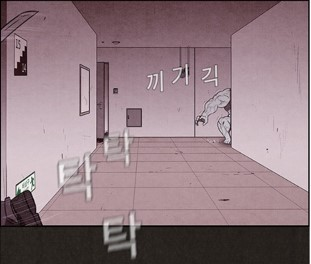

In [11]:
init_img

In [12]:
result = get_OCR_result(raw_1)

In [14]:
for pts, text, p in result :
    if text == "끼개각" :
        mask_img = np.zeros_like(raw_1)
        cv2.fillConvexPoly(mask_img, np.array(pts, dtype=np.int32), (255, 255, 255))
        break

In [15]:
pts

[[141.5430712064641, 64.37752817163539],
 [221.7195003849734, 57.73338338234116],
 [223.4569287935359, 87.62247182836461],
 [143.2804996150266, 94.26661661765884]]

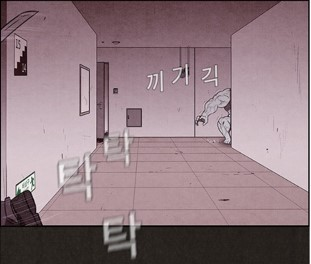

In [16]:
init_img

In [17]:
crop, pts_C = crop_center(init_img, pts)

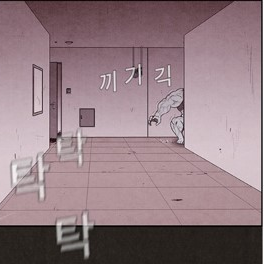

In [18]:
crop

In [19]:
masked_img, pts = make_mask_image(raw_1, "끼개각")

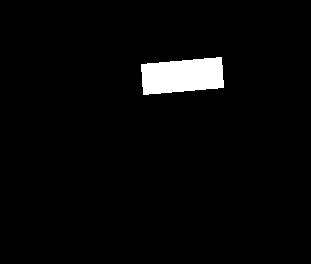

In [20]:
masked_img

In [21]:
crop_mask, crop_pts = crop_center(masked_img, pts)

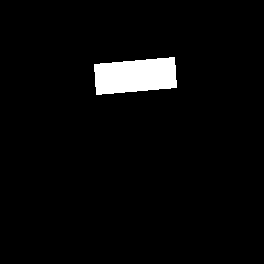

In [22]:
crop_mask

In [31]:
masked_image = masked_img.resize((512, 512))

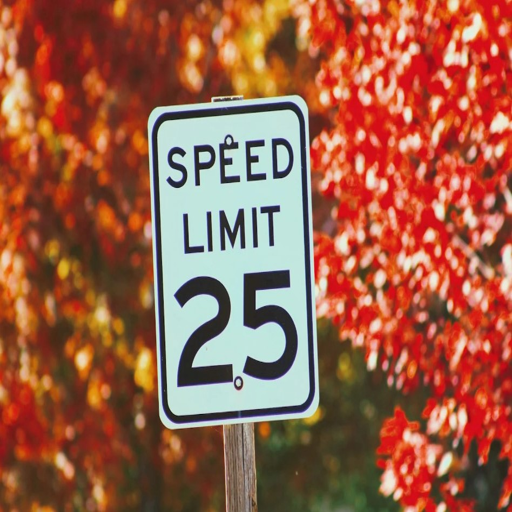

In [30]:
raw_image

In [21]:
# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt").to("cuda")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))
# a woman sitting on the beach with her dog

/home/taejukwon/anaconda3/envs/textdiffuser/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a speed limit sign on a pole in front of a tree


In [24]:
from diffusers import StableDiffusionInpaintPipeline
import torch

device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

unet/diffusion_pytorch_model.safetensors not found
Loading pipeline components...:  57%|█████▋    | 4/7 [00:02<00:02,  1.20it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


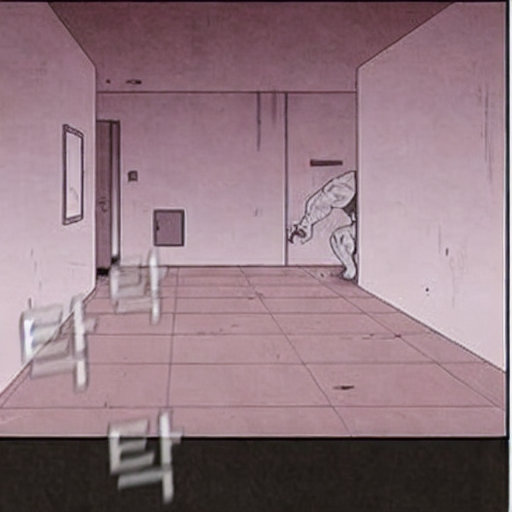

In [26]:
from PIL import Image

prompt = 'remove masked part'

guidance_scale=7.5
num_samples =1
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=crop,
    mask_image=crop_mask,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
    num_inference_steps=20
).images

images[0]

In [28]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


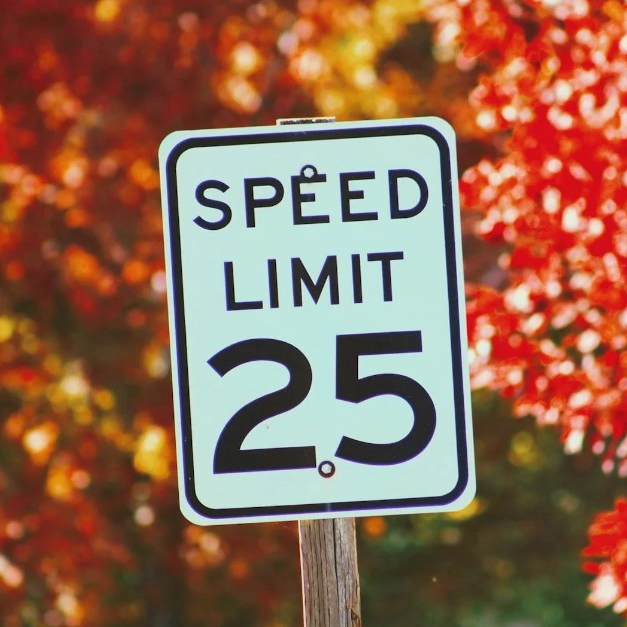

In [66]:
crop

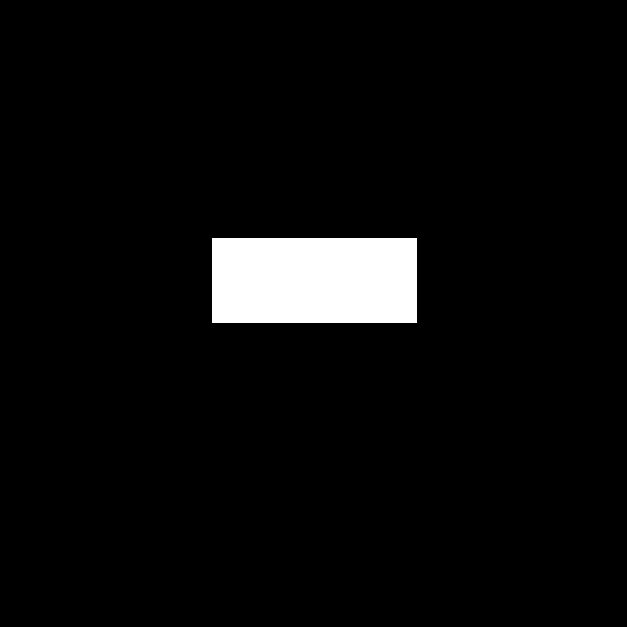

In [67]:
crop_mask

In [73]:
prompt = "remove masked part"

guidance_scale=7.5
num_samples =1
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=crop,
    mask_image=crop_mask,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


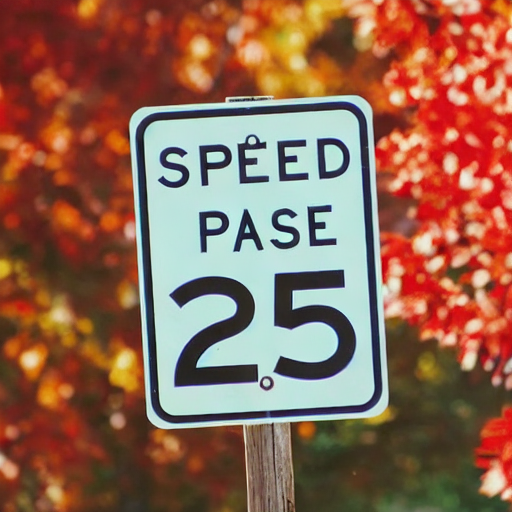

In [74]:
images[0]

In [62]:
def crop_center(image, pts) :
    pts = np.array(pts) # (4, 2)
    
    cp = np.mean(pts, axis=0)
    w, h = image.size
    d = min(w, h)
    if w < h : 
        ltx, rtx = 0, d
        lty = min(max(0, cp[1]- d//2), max(0, min(cp[1] + d//2, h) - d))
        rty = lty + d
    else : 
        lty, rty = 0, d
        ltx = min(max(0, cp[0]- d//2), max(0, min(cp[0] + d//2, w) - d))
        rtx = ltx + d
    crop_pts = (int(ltx), int(lty), int(rtx), int(rty))
    return image.crop(crop_pts), crop_pts

def generate_image(init_img, mask_text):
    prompt = "remove masked part"

    guidance_scale=7.5
    num_samples =1
    generator = torch.Generator(device="cuda").manual_seed(0)
    # init_img = Image.fromarray(init_img)
    mask_img, pts = make_mask_image(init_img, mask_text)
    
    # crop_init_img, crop_pts = crop_center(init_img, pts)
    # crop_mask_img, crop_pts = crop_center(mask_img, pts)
    
    # w, h = crop_init_img.size
    # image = crop_init_img.resize((512, 512))
    # masked_image = crop_mask_img.resize((512, 512))
    # output_image = pipe.sample(crop_init_img.resize((512, 512)), crop_mask_img.resize((512, 512)), prompt)
    
    images = pipe(
    prompt= prompt,
    image=init_img.resize((512, 512)),
    mask_image=mask_img.resize((512, 512)),
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
    ).images
    
    images.insert(0, init_img)
    output_image = images[1]
    # output_image = output_image.resize((w, h))
    
    # init_img.paste(output_image, (crop_pts[0], crop_pts[1]))
    return output_image

In [66]:
img = Image.open("/mnt/c/Users/USER/LABis/DiffUTE/figure/webtoon1.jpg")

In [67]:
output = generate_image(img, "끼개각")

100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


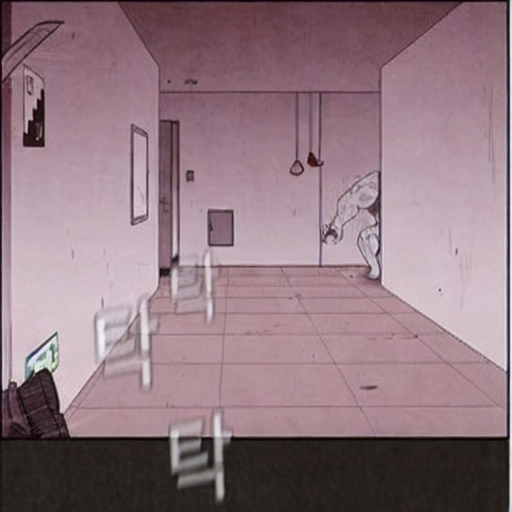

In [68]:
output

In [ ]:
def iteration()

In [31]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)

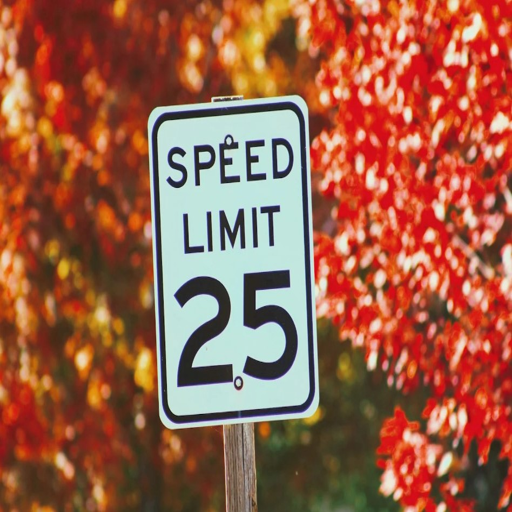

In [48]:
image

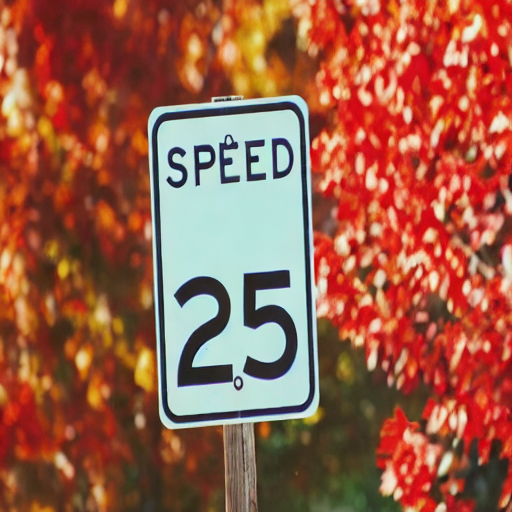

In [47]:
images[1]

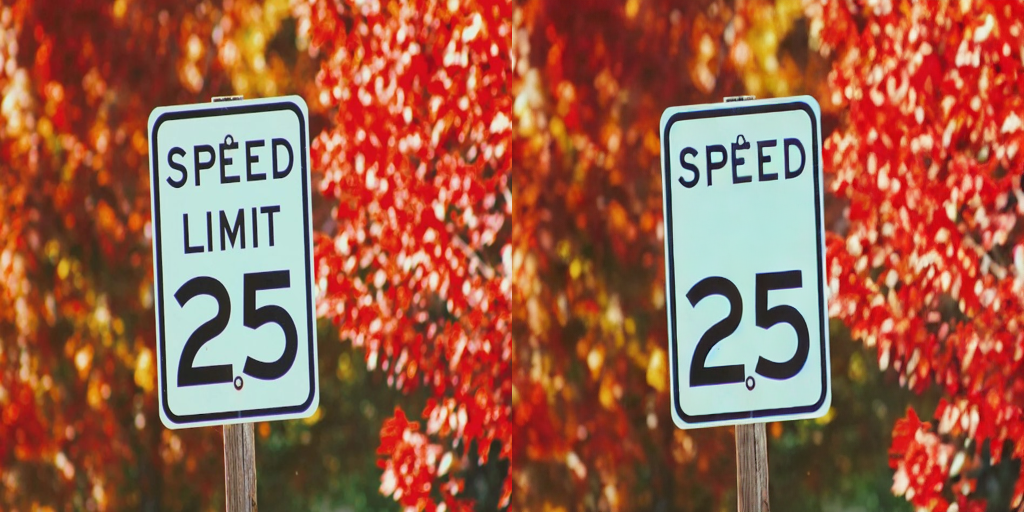

In [32]:
image_grid(images, 1, num_samples + 1)

In [ ]:
#Add croping 
import gradio as gr

def captioning(img):
    inputs = processor(img, return_tensors="pt").to("cuda")
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)

    return(caption)

def inpainting(dict, prompt):
  image =  dict['image'].convert("RGB").resize((512, 512))
  mask_image = dict['mask'].convert("RGB").resize((512, 512))
  negative_prompt = "low-res, bad anatomy, extra digit, fewer digits, cropped, worst quality, low quality, watermark, unreadable text, messy words, distorted text, disorganized writing, advertising picture"
#   prompt = prompt + "best quality, extremely detailed,4k, HD, supper legible text,  clear text edges,  clear strokes, neat writing, no watermarks"  
  images = pipe(prompt=prompt, image=image, mask_image=mask_image, negative_prompt=negative_prompt).images

  return(images[0])

with gr.Blocks() as demo: 
    gr.Markdown("# LET'S GO INPAINTING")
    with gr.Tab("Captioning"):
        image_input = gr.Image()
        text_output = gr.Textbox()
        caption_button = gr.Button("Captioning")
    with gr.Tab("Inpainting"):
        with gr.Row():
            with gr.Column():
                inputs=[
                    gr.Image(source = 'upload', tool = 'sketch', type = 'pil'),
                    gr.Textbox(label = 'prompt', value="copy your caption")
                    ]
            image_output = gr.Image()
        inpaint_button = gr.Button("Inpainting")

    caption_button.click(captioning, inputs=image_input, outputs=text_output)
    inpaint_button.click(inpainting, inputs=inputs, outputs=image_output)

demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


/home/labis-jaeyun/anaconda3/envs/inpainting/lib/python3.9/site-packages/transformers/generation/utils.py:1384: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 50/50 [00:07<00:00,  7.14it/s]
